# CPU PARALLELISATION CODE

The first few steps are for preprocessing.

This notebook has the entire progress of how the iikmc algorithm was modified for cpu based parallisation as ram crashed due to high amount of data. Proper markdowns are present mentioning results.

For more details refer to the paper but markdowns should suffice in understanding progress


In [1]:
import psutil, os, time, threading
def memwatch():
    while True:
        print(f"RAM {psutil.virtual_memory().percent:5.1f}% ", end="\r")
        time.sleep(5)
threading.Thread(target=memwatch, daemon=True).start()


RAM   6.9% 

In [2]:
# Install necessary packages
!pip install rasterio joblib cupy-cuda11x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 MB 5.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import rasterio
import os
from concurrent.futures import ThreadPoolExecutor

In [4]:
# Mount Google Drive if using large datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Dataset path (adjust this to your drive folder)
dataset_path = '/content/drive/MyDrive/PDC/dataset'

In [6]:
def load_bands(scene):
    suf = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
    stacks = []
    for s in suf:
        f = next(f for f in os.listdir(scene) if s in f)
        with rasterio.open(os.path.join(scene,f)) as src:
            b = src.read(1).astype(np.float32)
            b[b == src.nodata] = np.nan   # just drop nodata / border
            b /= 10000.0
            stacks.append(b)
    return np.stack(stacks, -1)


In [7]:
def flatten_scene(scene_path):
    # reads the six SR bands, converts nodata (‑9999) → NaN, scales to [0‑1]
    img = load_bands(scene_path)            # shape: (rows, cols, 6)

    # reshape to (n_pixels, 6) and keep rows that have *no* NaNs
    flat   = img.reshape(-1, 6)
    valid  = ~np.isnan(flat).any(axis=1)
    return flat[valid]                      # array of good spectra


In [8]:
import matplotlib.pyplot as plt
import pathlib, os, numpy as np, textwrap

dataset_dir = pathlib.Path(dataset_path)   # you set this earlier

# ---------- helper that counts kept pixels ----------
def audit_scene(scene_path):
    img = load_bands(scene_path)                 # (rows, cols, 6)
    rows, cols, _ = img.shape
    total = rows * cols

    # we’re *not* masking clouds here, only nodata
    kept = (~np.isnan(img).any(axis=-1)).sum()
    ratio = kept / total
    return total, kept, ratio

# ---------- loop and print ----------
print("scene".ljust(30), "total_px".rjust(10),
      "kept_px".rjust(10), "ratio".rjust(7))
for scene in sorted(dataset_dir.iterdir()):
    if not scene.is_dir(): continue
    total, kept, r = audit_scene(scene)
    print(scene.name.ljust(30), f"{total:,}".rjust(10),
          f"{kept:,}".rjust(10), f"{r*100:5.1f}%".rjust(7))


scene                            total_px    kept_px   ratio
scene1                         59,996,291 40,652,607   67.8%
scene2                         58,379,981 40,576,321   69.5%
scene3                         60,461,951 40,686,725   67.3%
scene4                         58,074,741 40,646,486   70.0%
scene5                         59,146,581 40,635,746   68.7%


These ratios confirm that we have chosen the right amount of pixels from each secene.

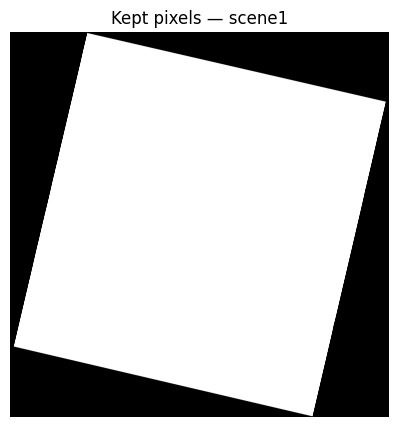

In [ ]:
def preview_mask(scene_path):
    img = load_bands(scene_path)
    valid = ~np.isnan(img).any(axis=-1)          # True = kept
    plt.figure(figsize=(5,5))
    plt.imshow(valid, cmap='gray')
    plt.title(f"Kept pixels — {scene_path.name}")
    plt.axis('off')
    plt.show()

# ---- call it on one scene ----
some_scene = next(iter(sorted(dataset_dir.iterdir())))
preview_mask(some_scene)    # change if you want another scene


This preview mask confirms that the selected data is correct. The reason I am doing this step here is because we made a grave mistake the previous time by using aerosol tiff file to remove cloud mask which removed all data and we found out after clustering. So this confirms that the white region has been selected by us before we move on to clustering.





In [10]:


pip install numpy tqdm


In [9]:
from pathlib import Path

dataset_dir = Path("/content/drive/MyDrive/PDC/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

flat_scenes = [flatten_scene(p) for p in scene_paths]   # ← now works
print([f.shape for f in flat_scenes])                   # sanity‑check


[(40652607, 6), (40576321, 6), (40686725, 6), (40646486, 6), (40635746, 6)]


The code below replicates the Intra Node one in paper (parallelisation before 3rd loop) but resources did not allow its successful execution here, nor on Kaggle. Concluding that 30gb ram is not sufficient for this. The code was modified step by step to see what works.

In [ ]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import trange            # neat progress bar

def iikmc_cpu(scenes, k=8, max_iter=100, tol=0.01, n_workers=None):
    """
    Inter‑Image k‑Means Clustering (CPU version)

    scenes      list(ndarray) – each (n_pixels_i, n_bands)
    k           number of clusters
    tol         stop when changed / total_pixels < tol
    returns     centers (k, n_bands), list(labels_i)
    """
    # ---------- class‑centre initialisation (Alg. 1 + 4) ----------
    stacked     = np.vstack(scenes)
    mins        = stacked.min(axis=0)
    maxs        = stacked.max(axis=0)
    interval    = (maxs - mins) / k
    centers     = np.array([mins + interval/2 + i*interval for i in range(k)],
                           dtype=np.float32)                # shape (k, n_bands)

    # allocate label arrays once
    labels      = [np.full(s.shape[0], -1, dtype=np.int32) for s in scenes]
    total_px    = sum(s.shape[0] for s in scenes)
    n_bands     = centers.shape[1]

    # ---------- main loop (Alg. 3 + 6) ----------
    for it in trange(max_iter, desc="IIkMC", unit="iter"):
        changed       = 0
        # global accumulators for new centres
        sums_global   = np.zeros_like(centers,  dtype=np.float64)
        counts_global = np.zeros(k,           dtype=np.int64)

        # ---- classify one scene (runs in a worker) ----
        def classify(idx):
            X   = scenes[idx]                                # (n_i, n_bands)
            # Euclidean distance to every centre (vectorised)
            d   = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            new = np.argmin(d, axis=1).astype(np.int32)      # (n_i,)
            # stats for this scene
            sums  = np.zeros_like(centers, dtype=np.float64)
            for c in range(k):
                mask = (new == c)
                if mask.any():
                    sums[c] = X[mask].sum(axis=0)
            return idx, new, (labels[idx] != new).sum(), sums, np.bincount(new, minlength=k)

        # ---- parallel over scenes (intra‑node) ----
        with ThreadPoolExecutor(max_workers=n_workers) as pool:
            for idx, new_lbl, chg, s_local, cnt_local in as_completed(
                    [pool.submit(classify, i) for i in range(len(scenes))]):
                labels[idx]  = new_lbl
                changed     += chg
                sums_global += s_local
                counts_global += cnt_local

        # ---- update centres (Alg. 6 line 8) ----
        mask = counts_global > 0
        centers[mask] = sums_global[mask] / counts_global[mask, None]

        # ---- convergence test ----
        if changed / total_px < tol:
            print(f"\nConverged in {it+1} iterations – changed {changed/total_px:.4%}")
            break

    return centers.astype(np.float32), labels


In [ ]:
centers, scene_labels = iikmc_cpu(
        flat_scenes,
        k=8,
        max_iter=100,
        tol=0.01,
        n_workers=None)


IIkMC:   0%|          | 0/100 [00:00<?, ?iter/s]

Crashed as ram exceeded, will do a vanilla version processing one image at a time

In [ ]:
"""
Streaming CPU implementation of Inter‑Image k‑Means Clustering (IIkMC)
   • Processes one scene at a time  ➟ memory ~ size_of_largest_scene
   • Uses centre‑shift tolerance instead of 'nChanged / total' to avoid
     storing labels from previous iterations
   • Still pure NumPy ➟ portable, no external compile step
"""

import numpy as np, os, rasterio
from pathlib import Path
from tqdm import trange

# ---------- helpers you already have ----------

def load_bands(scene):
    suf = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
    stacks = []
    for s in suf:
        f = next(f for f in os.listdir(scene) if s in f)
        with rasterio.open(os.path.join(scene, f)) as src:
            b = src.read(1).astype(np.float32)
            b[b == src.nodata] = np.nan
            b /= 10000.0
            stacks.append(b)
    return np.stack(stacks, -1)          # (rows, cols, 6)

def flatten_scene(scene):
    img  = load_bands(scene)             # nodata → NaN
    flat = img.reshape(-1, 6)
    return flat[~np.isnan(flat).any(1)]  # (n_valid, 6)

# ---------- new: streaming IIkMC ----------

def iikmc_stream(scene_paths, k=8, max_iter=100, tol_shift=1e-4):
    """
    Memory‑light IIkMC: loads and processes one scene at a time.
    tol_shift  – stop when centre RMS shift < tol_shift
    returns    – (centres, {scene_path: final_labels})
    """
    # --- global min/max pass (Alg.4) ---
    mins = np.full(6, np.inf,  dtype=np.float64)
    maxs = np.full(6, -np.inf, dtype=np.float64)
    for p in scene_paths:
        X = flatten_scene(p)
        mins = np.minimum(mins, X.min(0))
        maxs = np.maximum(maxs, X.max(0))

    interval = (maxs - mins) / k
    centres  = np.array([mins + interval/2 + i*interval for i in range(k)],
                        dtype=np.float32)          # (k,6)

    # storage for final labels
    final_labels = {p: None for p in scene_paths}

    for it in trange(max_iter, desc="IIkMC‑stream", unit="iter"):
        old = centres.copy().astype(np.float64)
        sums   = np.zeros_like(old)
        counts = np.zeros(k, dtype=np.int64)

        # ---- single pass over all scenes ----
        for p in scene_paths:
            X = flatten_scene(p)
            # distance^2 without sqrt ➟ less RAM
            d2 = ((X[:, None, :] - centres[None, :, :]) ** 2).sum(2)
            lbl = np.argmin(d2, axis=1).astype(np.int32)

            # accumulate
            for c in range(k):
                mask = (lbl == c)
                if mask.any():
                    sums[c]   += X[mask].sum(0)
                    counts[c] += mask.sum()

            final_labels[p] = lbl  # keep only current iter's labels

        # ---- update centres (Alg.6) ----
        mask = counts > 0
        centres[mask] = (sums[mask] / counts[mask, None]).astype(np.float32)

        # ---- convergence: centre shift ---
        shift = np.linalg.norm(centres - old) / k
        if shift < tol_shift:
            print(f"\nConverged in {it+1} iterations  –  centre shift {shift:.2e}")
            break

    return centres, final_labels


In [ ]:
dataset_dir = Path("/content/drive/MyDrive/PDC/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

centres, labels_dict = iikmc_stream(
        scene_paths,
        k=8,
        max_iter=100,
        tol_shift=1e-4)     # tweak if it stops too soon / late


IIkMC‑stream:   0%|          | 0/100 [00:00<?, ?iter/s]

Ram still crashing, trying Block‑wise IIkMC (process 1 M pixels at a time)

In [11]:
from tqdm import trange


iikmc_block() (the memory‑safe version I sent last) is serial
by design—one thread, low RAM.

In [12]:
def iikmc_block(stream_paths, k=8, chunk=1_000_000, tol_shift=1e-4, max_iter=100):
    # init mins/maxs
    mins = np.full(6, np.inf)
    maxs = np.full(6, -np.inf)
    for p in stream_paths:
        X = flatten_scene(p)
        mins = np.minimum(mins, X.min(0))
        maxs = np.maximum(maxs, X.max(0))
    centres = np.stack([mins + (i+0.5)*(maxs-mins)/k for i in range(k)]).astype(np.float32)

    labels_dict = {}
    for it in trange(max_iter, desc="IIkMC‑block"):
        old = centres.copy()
        sums = np.zeros_like(centres, np.float64)
        cnts = np.zeros(k, np.int64)

        # ----- one pass through all scenes -----
        for p in stream_paths:
            X = flatten_scene(p)            # (n_i, 6)
            n  = X.shape[0]
            lbls = np.empty(n, np.int32)

            # process in blocks of ≤ chunk rows
            for start in range(0, n, chunk):
                end   = min(start+chunk, n)
                lbls[start:end] = classify_block(X[start:end], centres)

            # accumulate
            for c in range(k):
                mask = lbls == c
                if mask.any():
                    sums[c] += X[mask].sum(0)
                    cnts[c] += mask.sum()
            labels_dict[p] = lbls

        # update centres
        mask = cnts > 0
        centres[mask] = (sums[mask] / cnts[mask, None]).astype(np.float32)

        shift = np.linalg.norm(centres - old) / k
        if shift < tol_shift:
            print(f"\nconverged {it+1} its  shift {shift:.2e}")
            break
    return centres, labels_dict


In [13]:
def classify_block(X_block, centres):
    # Euclidean distances, but we avoid allocating (n×k) full matrix
    # by expanding centres one at a time
    k, _ = centres.shape
    labels = np.empty(X_block.shape[0], np.int32)
    for c in range(k):
        d2 = np.sum((X_block - centres[c])**2, axis=1)
        if c == 0:
            best_d2   = d2
            best_lbl  = np.zeros_like(d2, np.int32)
        else:
            mask = d2 < best_d2
            best_d2[mask] = d2[mask]
            best_lbl[mask] = c
    labels[:] = best_lbl
    return labels


In [14]:
dataset_dir = Path("/content/drive/MyDrive/PDC/dataset")
scene_paths = sorted(p for p in dataset_dir.iterdir() if p.is_dir())

centres, labels_dict = iikmc_block(
        scene_paths,
        k=8,
        max_iter=10,
        tol_shift=1e-4)     # tweak if it stops too soon / late


IIkMC‑block:   0%|          | 0/10 [00:00<?, ?it/s]

IIkMC‑block:  10%|█         | 1/10 [02:46<24:56, 166.29s/it]

IIkMC‑block:  20%|██        | 2/10 [05:25<21:35, 161.90s/it]

IIkMC‑block:  30%|███       | 3/10 [08:00<18:31, 158.81s/it]

IIkMC‑block:  40%|████      | 4/10 [10:35<15:44, 157.36s/it]

IIkMC‑block:  50%|█████     | 5/10 [13:14<13:09, 157.89s/it]

IIkMC‑block:  60%|██████    | 6/10 [15:52<10:32, 158.04s/it]

IIkMC‑block:  70%|███████   | 7/10 [18:29<07:52, 157.57s/it]

IIkMC‑block:  80%|████████  | 8/10 [21:04<05:13, 156.71s/it]

IIkMC‑block:  90%|█████████ | 9/10 [23:49<02:39, 159.43s/it]

IIkMC‑block: 100%|██████████| 10/10 [26:25<00:00, 158.60s/it]


This took 25 minutes and successfully worked to our surprise. Blocking significantly helped.

<ipython-input-17-e219d748404c>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])


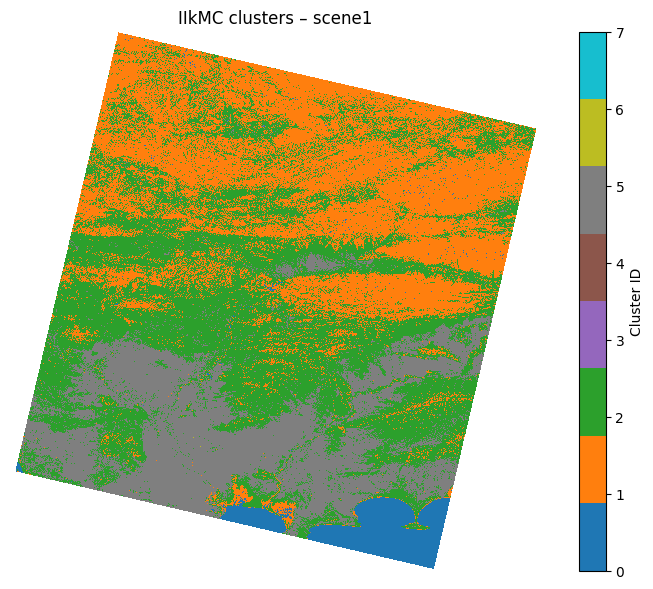

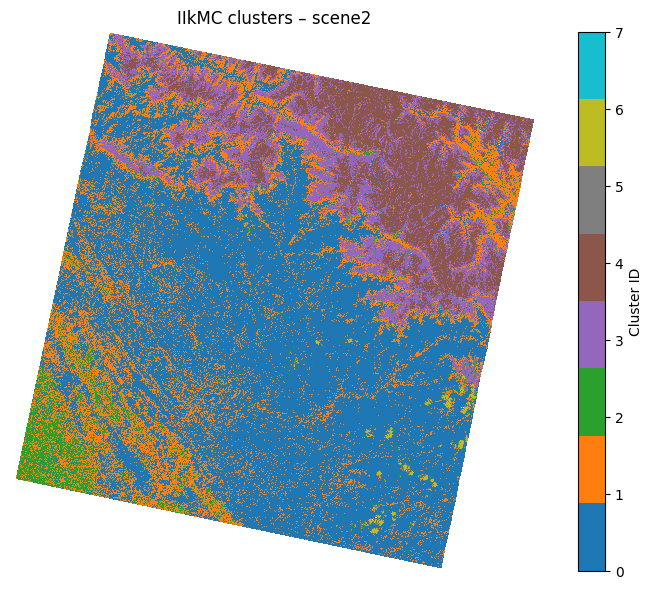

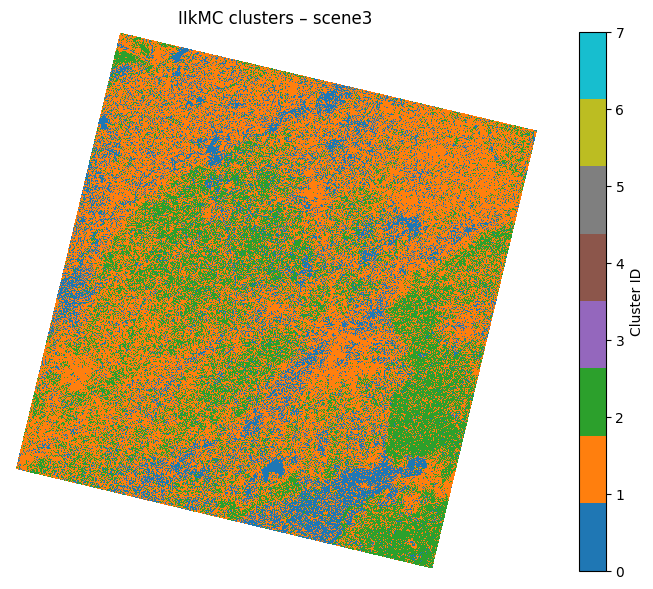

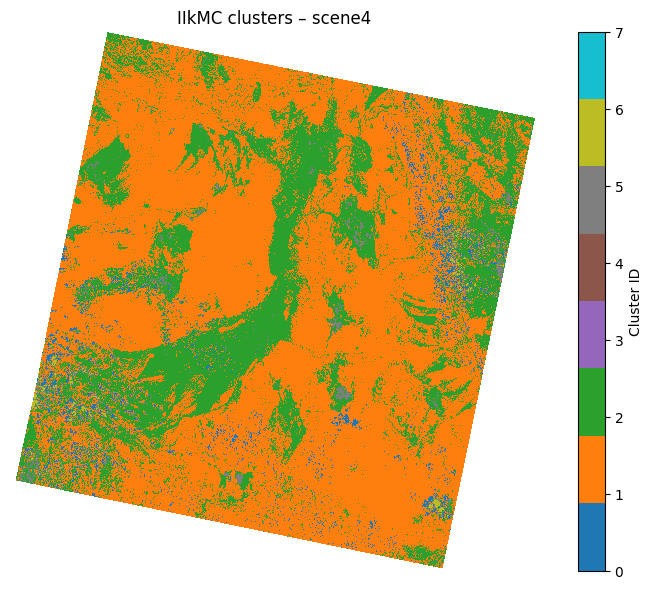

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# ---------- helper (same mask logic as flatten_scene) ----------
def map_labels_back(scene_path, labels_1d):
    img  = load_bands(scene_path)                 # (rows, cols, 6) with NaNs
    valid = ~np.isnan(img).any(-1)                # True = pixel kept earlier
    rows, cols = img.shape[:2]

    if valid.sum() != len(labels_1d):
        raise ValueError(f"label mismatch: {valid.sum()} vs {len(labels_1d)}")

    out = np.full(rows*cols, np.nan, np.float32)
    out[valid.ravel()] = labels_1d.astype(np.float32)
    return out.reshape(rows, cols)

# ---------- nice discrete palette ----------
def visualize_cluster_map(label_map, title="", k=8, figsize=(10,7)):
    cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])
    masked = np.ma.masked_where(np.isnan(label_map), label_map)
    plt.figure(figsize=figsize)
    plt.imshow(masked, cmap=cmap, interpolation='nearest')
    plt.title(title); plt.axis('off')
    plt.colorbar(ticks=range(k), label='Cluster ID')
    plt.show()

# ---------- run over every scene you've clustered ----------
for sc_path in scene_paths:
    lbl2d = map_labels_back(sc_path, labels_dict[sc_path])
    visualize_cluster_map(lbl2d,
        title=f"IIkMC clusters – {sc_path.name}", k=centres.shape[0])


Scene 5 crashed, need to clean memory before moving forward

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# ---------- helper (same mask logic as flatten_scene) ----------
def map_labels_back(scene_path, labels_1d):
    img  = load_bands(scene_path)                 # (rows, cols, 6) with NaNs
    valid = ~np.isnan(img).any(-1)                # True = pixel kept earlier
    rows, cols = img.shape[:2]

    if valid.sum() != len(labels_1d):
        raise ValueError(f"label mismatch: {valid.sum()} vs {len(labels_1d)}")

    out = np.full(rows*cols, np.nan, np.float32)
    out[valid.ravel()] = labels_1d.astype(np.float32)
    return out.reshape(rows, cols)

# ---------- nice discrete palette ----------
def visualize_cluster_map(label_map, title="", k=8, figsize=(10,7)):
    cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])
    masked = np.ma.masked_where(np.isnan(label_map), label_map)
    plt.figure(figsize=figsize)
    plt.imshow(masked, cmap=cmap, interpolation='nearest')
    plt.title(title); plt.axis('off')
    plt.colorbar(ticks=range(k), label='Cluster ID')
    plt.show()

<ipython-input-15-3a15cc9bc888>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10', k).colors[:k])


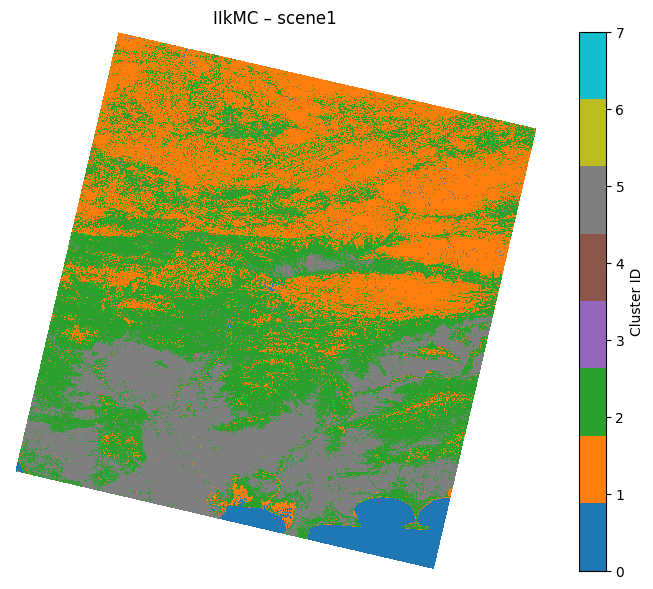

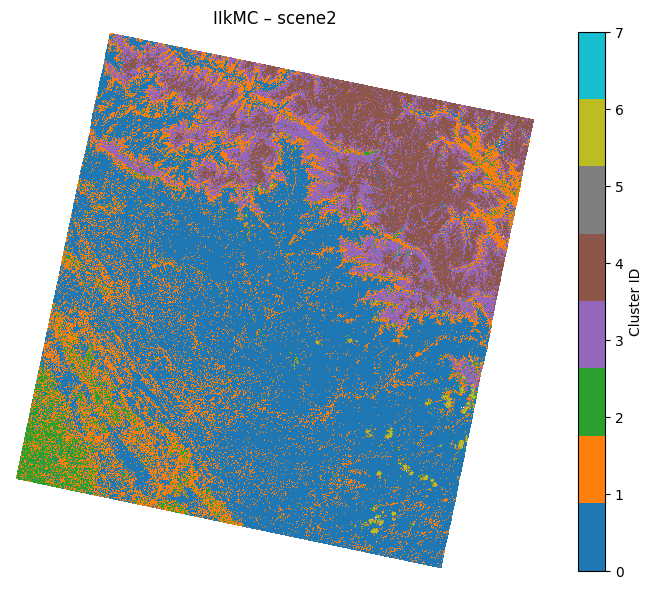

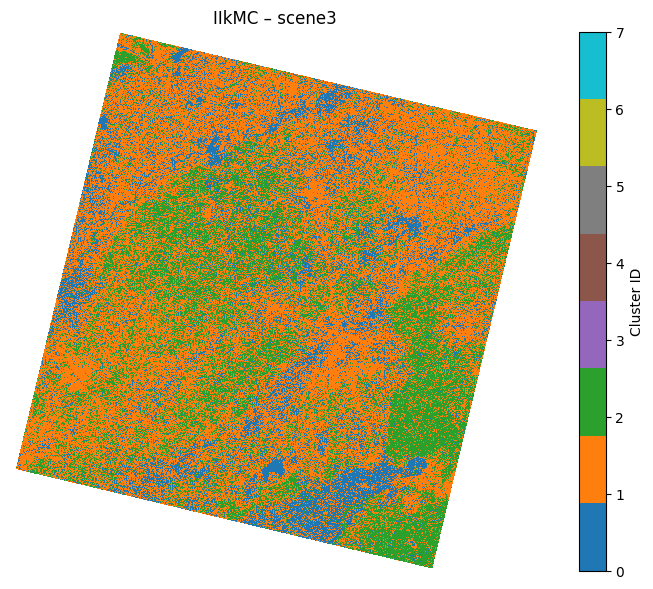

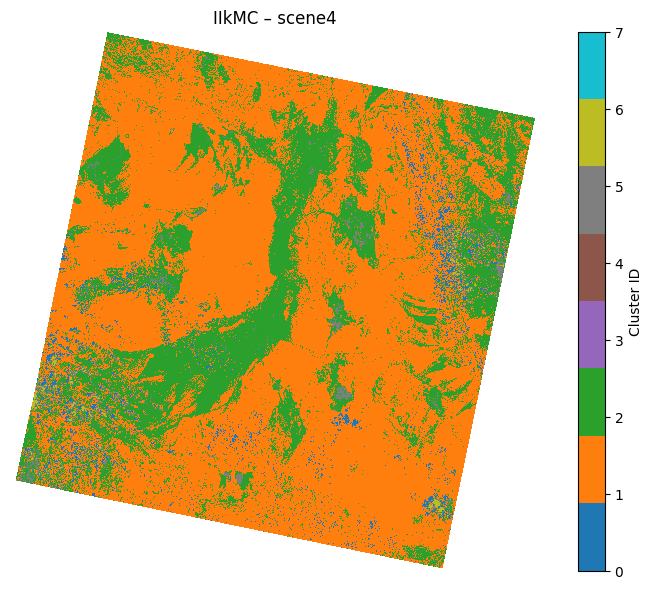

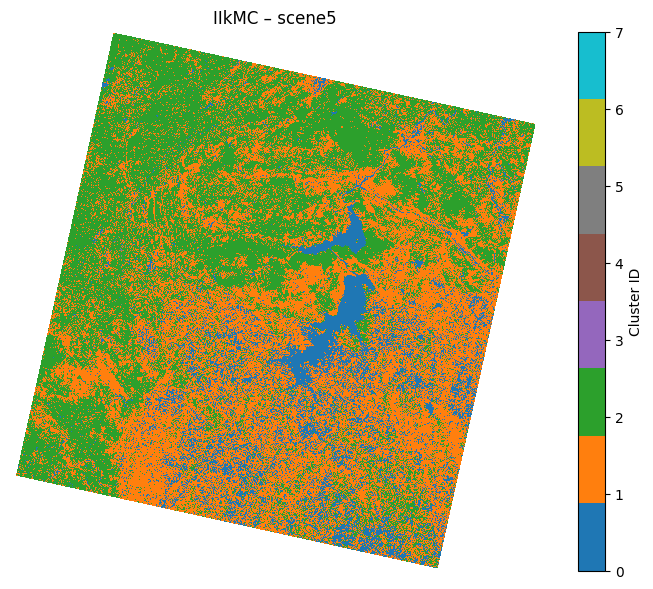

In [16]:
import gc, matplotlib.pyplot as plt

for sc_path in scene_paths:
    lbl2d = map_labels_back(sc_path, labels_dict[sc_path])
    visualize_cluster_map(lbl2d,
                          title=f"IIkMC – {sc_path.name}",
                          k=centres.shape[0])
    plt.close('all')          # free figure memory
    del lbl2d                 # drop the 2‑D label map
    gc.collect()              # force Python to return RAM
